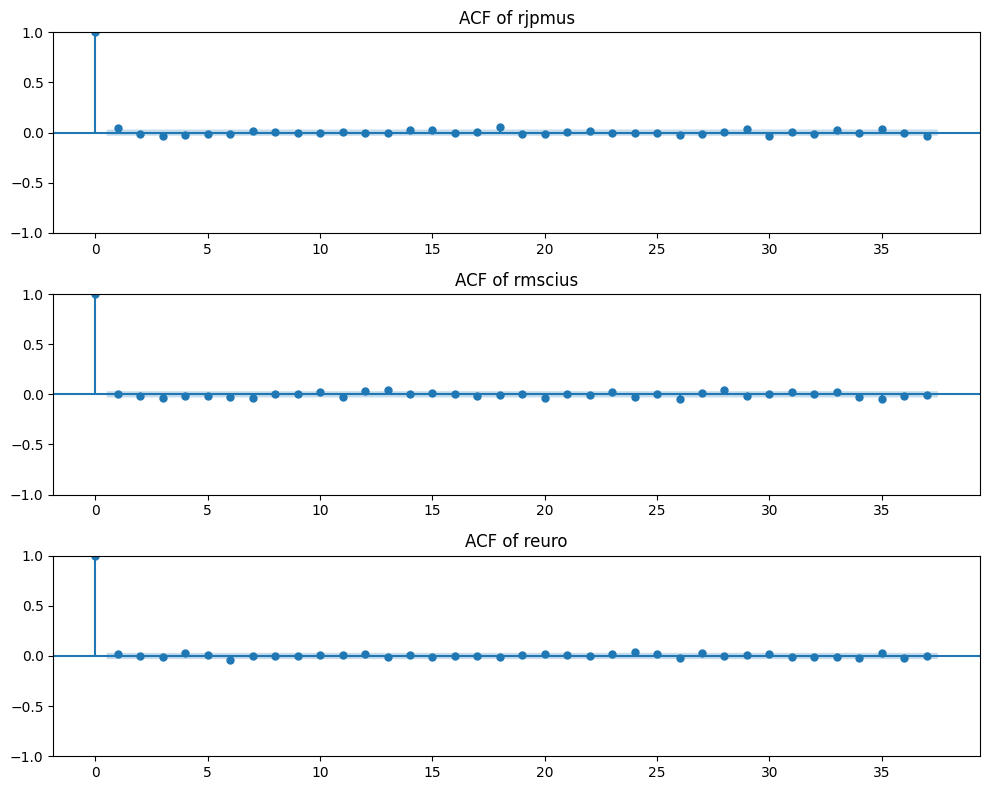

             JB Stat        P-value  Squared JB Stat  Squared P-value
rjpmus    632.581561  4.331710e-138     2.730062e+05              0.0
rmscius  2561.659459   0.000000e+00     1.808691e+06              0.0
reuro     525.659103  7.154446e-115     3.550772e+05              0.0


In [254]:
#EXERCISE 1: COMPUTE CORRELOGRAM AND GET JB STAT FOR THE SERIES AND THE SQUARED SERIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import jarque_bera

# Load data
df_ps1 = pd.read_csv("PS1 DATA - Sheet1.csv")

# Series names
series_names = ["rjpmus", "rmscius", "reuro"]

# Compute correlogram
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
for i, series in enumerate(series_names):
    plot_acf(df_ps1[series].dropna(), ax=axes[i], title=f"ACF of {series}")
plt.tight_layout()    
plt.show()

# Compute Jarque-Bera test
jb_results = {}
for series in series_names:
    stat, p = jarque_bera(df_ps1[series].dropna())[:2]
    stat_squared, p_squared = jarque_bera(df_ps1[series].dropna() ** 2)[:2]
    jb_results[series] = {
        "JB Stat": stat, "P-value": p, "Squared JB Stat": stat_squared, "Squared P-value": p_squared
    }
jb_df = pd.DataFrame(jb_results).T
print(jb_df)


#Looking at the results from the Jarque-Bera test, we see that the p-values for the series are all less than 0.05. This tells us that returns do not follow a normal distribution so we should reject normality. For the squared p-value we see that they are all 0, so this suggests volatility clustering- as assuming a linear model with a constant variance would not properly capture the time-varying volatility.
We note an absence of autocorrelation in the returns however, we do observe autocorrelation in the squared returns which again suggest volatility clustering.

In [255]:
#EXERCISE 2: TEST FOR INDEPENDENCE( I USED THE SIEGEL AND CASTELLAN RUNS TEST HERE)
from scipy.stats import rankdata
from statsmodels.tsa.stattools import acf, q_stat
from statsmodels.sandbox.stats.runs import runstest_1samp

# Load data again
df_ps1 = pd.read_csv("PS1 DATA - Sheet1.csv")

# Series names
series_names = ["rjpmus", "rmscius", "reuro"]

# Independence tests
iid_results = {}
for series in series_names:
    data = df_ps1[series].dropna()

    # Box-Ljung Q-Statistic
    lb_stat, lb_p = q_stat(acf(data, nlags=10, fft=False)[1:], len(data))

    # Siegel-Castellan Runs Test
    ranked_series = rankdata(data)
    z_stat, runs_p = runstest_1samp(ranked_series, cutoff="mean")

    # Store results
    iid_results[series] = {
        "Box-Ljung Q Stat": lb_stat[0],
        "Box-Ljung P-Value": lb_p[0],
        "S-C Z Stat": z_stat,
        "S-C P-Value": runs_p
    }

# Results to DataFrame
iid_df = pd.DataFrame(iid_results).T

print("\n=== Independence Test Results ===")
print(iid_df)


=== Independence Test Results ===
         Box-Ljung Q Stat  Box-Ljung P-Value  S-C Z Stat  S-C P-Value
rjpmus           8.365102           0.003825   -2.354514     0.018547
rmscius          0.000754           0.978098    0.727779     0.466749
reuro            2.221349           0.136114    0.664494     0.506374


#I computed two tests here: the Box-Ljung Q  and Siegel & Castellan(S-C) Runs test. The Box-Ljung test for correlation and the SC test for independence. Here are the results:

Rjpmus:
* The Box-Ljung Test p value is 0.003825 which is less than 0.05 so we reject the null hypothesis of independence. Meaning that past returns do have an affect on future returns (autocorrelation).
* The S-C runs test, a p-value of 0.018547 which is also less than 0.05 so we reject the null hypothesis of the returns moving randomly(not IID).

Rmscius
* The Box-Ljung Test p value is 0.978098 which is greater than 0.05 so we fail to reject the null hypothesis of independence. This suggests independence as there is no autocorrelation observed here.
* The S-C runs a p-value of 0.466749 which is also greater than 0.05 so we fail to reject the null hypothesis and so the returns appear IID.

Reuro
* The Box-Ljung Test p value is 0.136114 which is greater than 0.05 so we fail to reject the null hypothesis of independence. This suggests independence as there is no autocorrelation observed here.
* The S-C runs a p-value of 0.506374 which is also greater than 0.05 so we fail to reject the null hypothesis and so the returns appear IID.


            Alpha  Alpha P-Value           MLE           AIC           BIC
rjpmus   0.059951   9.201456e-03  -9821.224639  19648.449279  19667.328426
rmscius  0.225207   2.779028e-08 -14804.145039  29614.290077  29633.169225
reuro    0.074071   1.953329e-04 -12919.612777  25845.225555  25864.104702


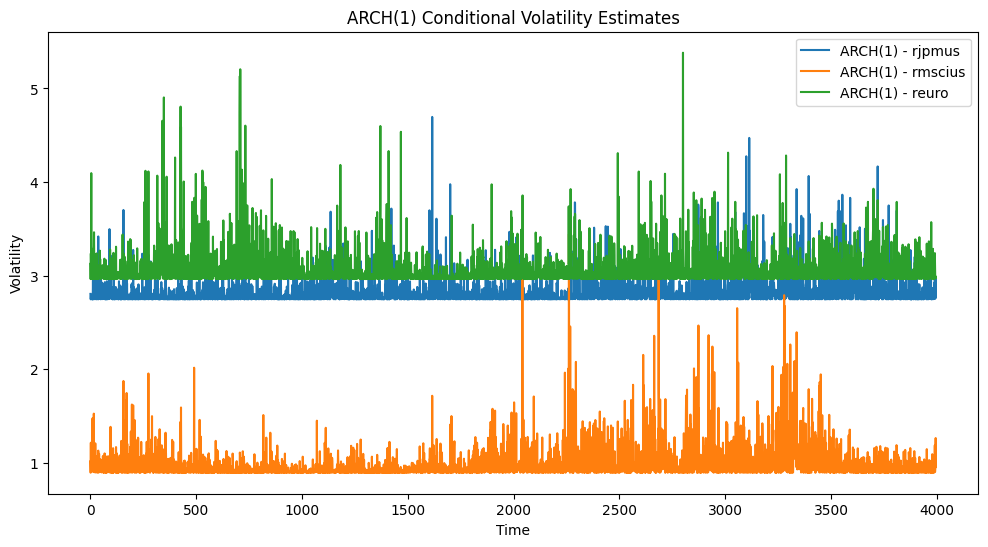

In [265]:
#QUEESTION 3: ARCH MODEL
from arch import arch_model 
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_ps1 = pd.read_csv("PS1 DATA - Sheet1.csv")

# Series names
series_names = ["rjpmus", "rmscius", "reuro"]

# Fit ARCH(1) model
arch_results = {} 
for series in series_names:
    data = df_ps1[series].dropna()* 1000 # Rescale the data to improve stability

    # Fit AR(1) model to get residuals
    ar_model = sm.tsa.ARIMA(data, order=(1, 0, 0)).fit()
    ar_resid = ar_model.resid

    # Fit ARCH(1) model
    arch_model_fit = arch_model(ar_resid, vol='ARCH', p=1).fit(disp="off")

    arch_results[series] = {
        "Alpha": arch_model_fit.params["alpha[1]"],
        "Alpha P-Value": arch_model_fit.pvalues["alpha[1]"],
        "MLE": arch_model_fit.loglikelihood,
        "AIC": arch_model_fit.aic,
        "BIC": arch_model_fit.bic
    }

# Results to DataFrame
arch_df = pd.DataFrame(arch_results).T
print(arch_df)

# Plot the conditional volatility for the three series
plt.figure(figsize=(12, 6))
for series, vol_series in volatility_series.items():
    plt.plot(vol_series, label=f"ARCH(1) - {series}")

plt.title("ARCH(1) Conditional Volatility Estimates")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()


The ARCH effects are all statistically significant as all the alpha p-values are less than 0.05. This confirms to us that past volatility influences future volatility. In addition to that, the conditional volatility graph that I included in my code helps visualize the volatility clustering. Of all the three series we see that the ARCH(1) model captures the clustering well. However, I think the ARCH model would  be most relevant for the rmscius series as that is the series that we see the most clustering, then the reuro and lastly the rjpmus series.

In [262]:
#EXERCISE 4: LOOKING AT SKEWNESS & KURTOSIS OF THE SHOCK(UT)
from scipy.stats import skew, kurtosis

# Load data
df_ps1 = pd.read_csv("PS1 DATA - Sheet1.csv")

# Series names
series_names = ["rjpmus", "rmscius", "reuro"]

# Compute skewness and kurtosis for ARCH(1) residuals
shock_results = {}
for series in series_names:
    data = df_ps1[series].dropna() * 1000 

    # Fit ARCH(1) model
    arch_model_fit = arch_model(data, vol='ARCH', p=1).fit(disp="off")

    ut = arch_model_fit.resid

    # Skewness & Kurtosis
    skewness = skew(ut)
    kurt = kurtosis(ut) + 3  # Adjust for excess kurtosis

    shock_results[series] = {
        "Skewness": skewness,
        "Kurtosis": kurt
    }
    
shock_df = pd.DataFrame(shock_results).T
print("\n=== Skewness & Kurtosis ===")
print(shock_df)
print("• If u_t(the shock) is normally distributed, then kurtosis should equal 3.")


=== Skewness & Kurtosis ===
         Skewness  Kurtosis
rjpmus  -0.343599  4.824020
rmscius -0.111765  6.916041
reuro   -0.033056  4.775596
• If u_t(the shock) is normally distributed, then kurtosis should equal 3.


For the negative skews, it tells us that the distribution has a long left tail and there are more extreme negative shocks in the distribution. In terms of Kurtosis, all have excess kutosis of greater than 1, so their kurtosis is greater than which indicates fat tails- so more extreme events happen more often that in a normal distribution. A kurtosis is equal to 3 when the shock (ut) follows a normal distribution. 


=== GARCH(1,1) Model Results ===
               Mu     Omega     Alpha      Beta       MLE-log           AIC  \
rjpmus   0.028587  0.069453  0.027710  0.963602  -9690.463936  19388.927872   
rmscius  0.016435  0.004909  0.051272  0.944687  -5192.417725  10392.835449   
reuro   -0.027744  0.092416  0.037243  0.953264 -10022.140394  20052.280789   

                  BIC  
rjpmus   19414.100068  
rmscius  10418.007646  
reuro    20077.452985  


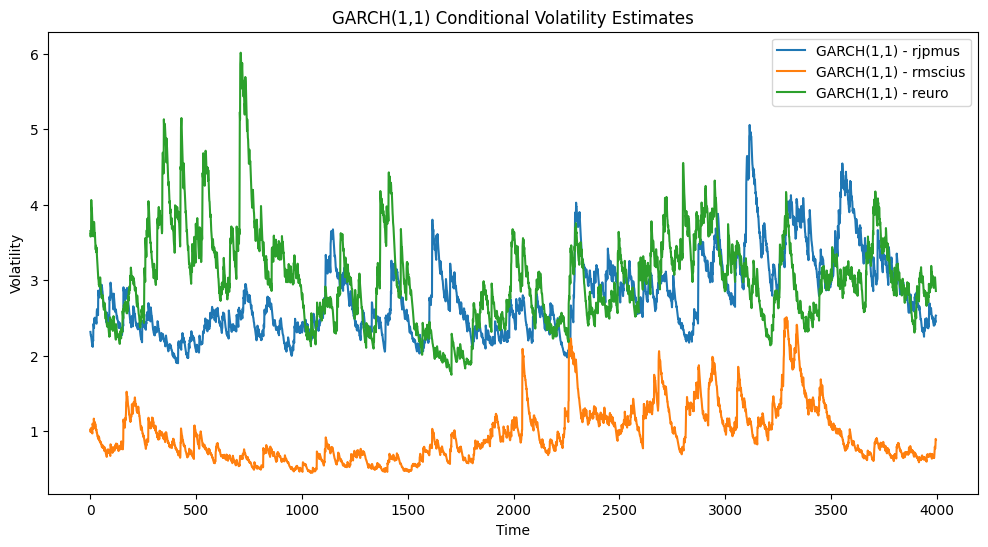

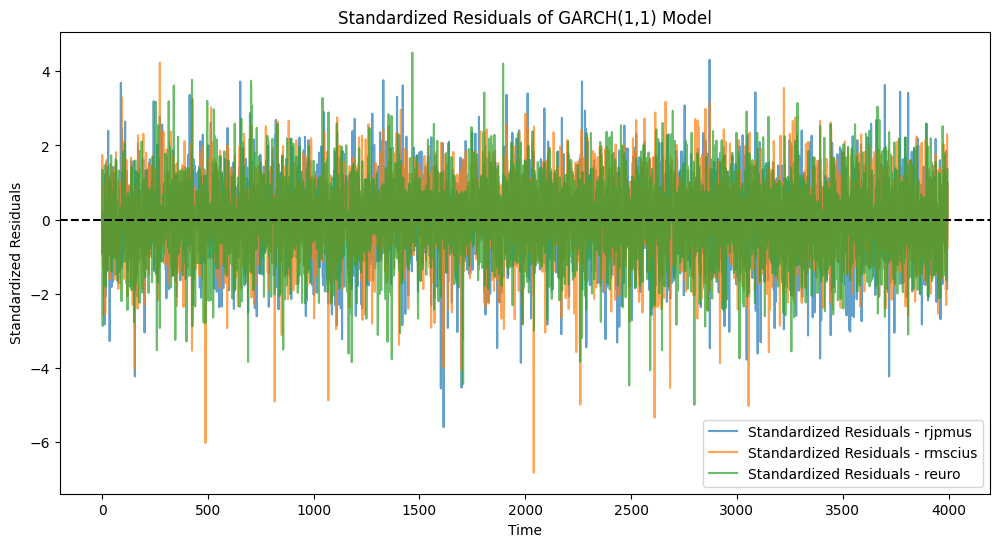


=== IID Test (S-C Runs Test) ===
rjpmus - Z-Statistic: 1.7403, P-Value: 0.0818
Standardized residuals for rjpmus appear i.i.d.

rmscius - Z-Statistic: 0.6645, P-Value: 0.5064
Standardized residuals for rmscius appear i.i.d.

reuro - Z-Statistic: 2.3732, P-Value: 0.0176
Standardized residuals for reuro are NOT i.i.d.


=== Conditional Variance Forecast ===
rjpmus:
1-step ahead variance: 6.2497
2-step ahead variance: 6.2648
3-step ahead variance: 6.2799
4-step ahead variance: 6.2948

rmscius:
1-step ahead variance: 0.7886
2-step ahead variance: 0.7903
3-step ahead variance: 0.7921
4-step ahead variance: 0.7938

reuro:
1-step ahead variance: 8.4516
2-step ahead variance: 8.4638
3-step ahead variance: 8.4759
4-step ahead variance: 8.4879



In [5]:
# EXERCISE 5: GARCH(1,1) MODEL
import statsmodels.api as sm
from arch import arch_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from statsmodels.sandbox.stats.runs import runstest_1samp

# Load data
df_ps1 = pd.read_csv("PS1 DATA - Sheet1.csv")

# Define scaling factors
scaling_factors = {"rjpmus": 1000, "rmscius": 100, "reuro": 500}

# Containers for results
garch = {}
conditional_variances = {}
standardized_residuals = {}
variance_forecasts = {}

# Fit GARCH model
def estimate_garch_model(series, title):
    # Fit AR(1) model
    ar_model = sm.tsa.ARIMA(series, order=(1, 0, 0)).fit()
    ar_resid = ar_model.resid  # Residuals for the GARCH model

    # Fit GARCH(1,1) model
    garch_model = arch_model(ar_resid, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp="off")

    # Store results
    garch[title] = {
        "Mu": garch_fit.params["mu"] if "mu" in garch_fit.params else np.nan,
        "Omega": garch_fit.params["omega"],
        "Alpha": garch_fit.params["alpha[1]"],
        "Beta": garch_fit.params["beta[1]"],
        "MLE-log": garch_fit.loglikelihood,
        "AIC": garch_fit.aic,
        "BIC": garch_fit.bic
    }
    # Store conditional variances
    conditional_variances[title] = garch_fit.conditional_volatility

    # Store standardized residuals
    standardized_residuals[title] = garch_fit.resid / garch_fit.conditional_volatility

    # Forecast variances
    forecasts = garch_fit.forecast(horizon=4)
    forecast_variances = forecasts.variance.iloc[-1].values
    variance_forecasts[title] = forecast_variances

# Estimate GARCH for all series
series_names = ["rjpmus", "rmscius", "reuro"]
for series in series_names:
    scaled_data = df_ps1[series].dropna() * scaling_factors[series]
    estimate_garch_model(scaled_data, series)

garch_df = pd.DataFrame(garch).T
print("\n=== GARCH(1,1) Model Results ===")
print(garch_df)

# Plot conditional variances
plt.figure(figsize=(12, 6))
for series, var_series in conditional_variances.items():
    plt.plot(var_series, label=f"GARCH(1,1) - {series}")
plt.title("GARCH(1,1) Conditional Volatility Estimates")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Plot standardized residuals
plt.figure(figsize=(12, 6))
for series, res_series in standardized_residuals.items():
    plt.plot(res_series, label=f"Standardized Residuals - {series}", alpha=0.7)
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Standardized Residuals of GARCH(1,1) Model")
plt.xlabel("Time")
plt.ylabel("Standardized Residuals")
plt.legend()
plt.show()

# Test for IID using S-C Runs Test
print(f"\n=== IID Test (S-C Runs Test) ===")
for series, res_series in standardized_residuals.items():
    ranked_series = rankdata(res_series.dropna())
    z_stat, runs_p_value = runstest_1samp(ranked_series, cutoff="mean")
    
    print(f"{series} - Z-Statistic: {z_stat:.4f}, P-Value: {runs_p_value:.4f}")

    if runs_p_value < 0.05:
        print(f"Standardized residuals for {series} are NOT i.i.d.")
    else:
        print(f"Standardized residuals for {series} appear i.i.d.")
    print("")

# Forecast conditional variances
print(f"\n=== Conditional Variance Forecast ===")
for series, forecast_values in variance_forecasts.items():
    print(f"{series}:")
    for step, var in enumerate(forecast_values, start=1):
        print(f"{step}-step ahead variance: {var:.4f}")
    print("")


#As we previously discussed in class,the effect of the shock is most prevalent in the 1-step ahead variance forecast, as it directly has ut in its equation, as we go to the 2-step, 3-step and 4-step, the effect of the shock diminishes. I can see this across the conditional varinace forecasts for all my three series. Although the effect reduces, it is still present and will always be felt as long as the alpha1 + gamma1 are less than 1.

Results for r_portfolio:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2275.58
Distribution:      Standardized Student's t   AIC:                           4561.16
Method:                  Maximum Likelihood   BIC:                           4592.63
                                              No. Observations:                 3995
Date:                      Mon, Mar 31 2025   Df Residuals:                     3994
Time:                              23:31:48   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------

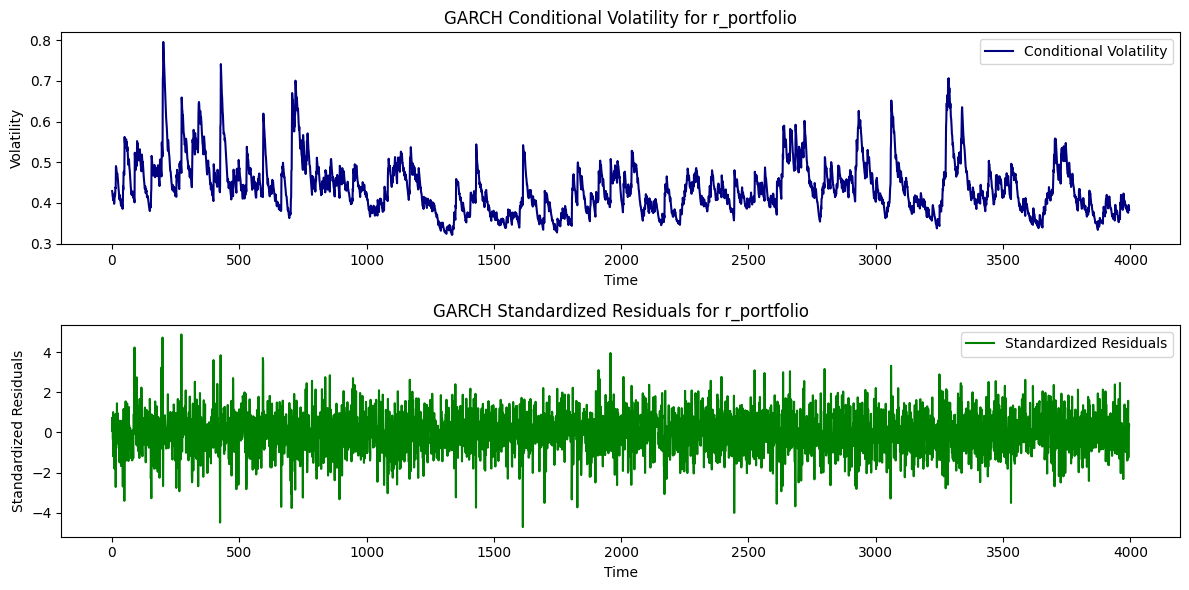


=== VaR and Expected Shortfall Results ===
1-day ahead 1% VaR: -0.879081
2-day ahead 1% VaR: -0.883345
1-day ahead 1% Expected Shortfall: 1.007440
2-day ahead 1% Expected Shortfall: 1.012326


In [1]:
#EXERCISE 6 - PORTFOLIO GARCH with student-t?
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm, t, jarque_bera
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox

# Load dataset
df = pd.read_csv("UK-US stock data - Sheet1.csv")

# Define portfolio weights (30% US Bonds, 30% UK Bonds, 20% US Stocks, 20% UK Stocks)
weights = np.array([0.30, 0.30, 0.20, 0.20])

# Compute portfolio returns using weighted sum
df['r_portfolio'] = (
    weights[0] * df['rjpmuk'] +
    weights[1] * df['rjpmus'] +
    weights[2] * df['rmsciuk'] +
    weights[3] * df['rmscius']
)

# Drop NaN values
df = df.dropna()
series = df['r_portfolio'] * 100  # Scale for numerical stability
series_name = df['r_portfolio'].name

# Fit AR(1) model for the mean equation
ar_model = AutoReg(series, lags=1, trend="c").fit()
residuals = ar_model.resid  #Get the residuals

# Fit GARCH(1,1) model with Student-t innovations
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, dist='t')
garch_result = garch_model.fit(disp=0)

# Print GARCH Model Summary
print(f"Results for {series_name}:")
print(garch_result.summary())

# Get standardized residuals
garch_std_resids = garch_result.resid / garch_result.conditional_volatility

# Perform Box-Ljung Test for autocorrelation in standardized residuals
lb_test = acorr_ljungbox(garch_std_resids, lags=[20], return_df=True)
lb_stat, lb_pval = lb_test["lb_stat"].values[0], lb_test["lb_pvalue"].values[0]

# Perform Jarque-Bera Test for normality
jb_stat, jb_p_value = jarque_bera(garch_std_resids)

# Print test results
print(f"\n=== Serial Correlation (BL) and Normality (JB) Test Results ===")
print(f"Box-Ljung Test for {series_name}:")
print(f"\t Box-Ljung Stat: {lb_stat:.4f} and p-value: {lb_pval:.4f}")
print(f"Jarque-Bera Test for {series_name}:")
print(f"\t Jarque-Bera Stat: {jb_stat:.4f} and p-value: {jb_p_value:.4f}")

# Plot Conditional Volatility & Standardized Residuals
plt.figure(figsize=(12, 6))

# Conditional Volatility
plt.subplot(2, 1, 1)
plt.plot(garch_result.conditional_volatility, label="Conditional Volatility", color='navy')
plt.title(f"GARCH Conditional Volatility for {series_name}")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()

# Standardized Residuals
plt.subplot(2, 1, 2)
plt.plot(garch_std_resids, label="Standardized Residuals", color='green')
plt.title(f"GARCH Standardized Residuals for {series_name}")
plt.xlabel("Time")
plt.ylabel("Standardized Residuals")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

# Forecast conditional variance for 1 and 2 days ahead
forecast = garch_result.forecast(horizon=2)
cond_vol_1_day = np.sqrt(forecast.variance.iloc[-1, 0])
cond_vol_2_day = np.sqrt(forecast.variance.iloc[-1, 1])

# Compute 1% VaR & Expected Shortfall using Student-t distribution
z_alpha = norm.ppf(0.01)  # Standard normal quantile
mean_r_portfolio = np.mean(df['r_portfolio'])

# Compute VaR
VaR_1_day = mean_r_portfolio + z_alpha * cond_vol_1_day
VaR_2_day = mean_r_portfolio + z_alpha * cond_vol_2_day

# Compute Expected Shortfall (Conditional VaR)
pdf_z_alpha = norm.pdf(z_alpha)
ES_1_day = mean_r_portfolio + (pdf_z_alpha / 0.01) * cond_vol_1_day
ES_2_day = mean_r_portfolio + (pdf_z_alpha / 0.01) * cond_vol_2_day

# Print VaR and Expected Shortfall results
print("\n=== VaR and Expected Shortfall Results ===")
print(f"1-day ahead 1% VaR: {VaR_1_day:.6f}")
print(f"2-day ahead 1% VaR: {VaR_2_day:.6f}")
print(f"1-day ahead 1% Expected Shortfall: {ES_1_day:.6f}")
print(f"2-day ahead 1% Expected Shortfall: {ES_2_day:.6f}")

GARCH(1,1) Model Results:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -11476.7
Distribution:      Standardized Student's t   AIC:                           22963.4
Method:                  Maximum Likelihood   BIC:                           22994.8
                                              No. Observations:                 3996
Date:                      Wed, Feb 19 2025   Df Residuals:                     3995
Time:                              00:02:34   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------

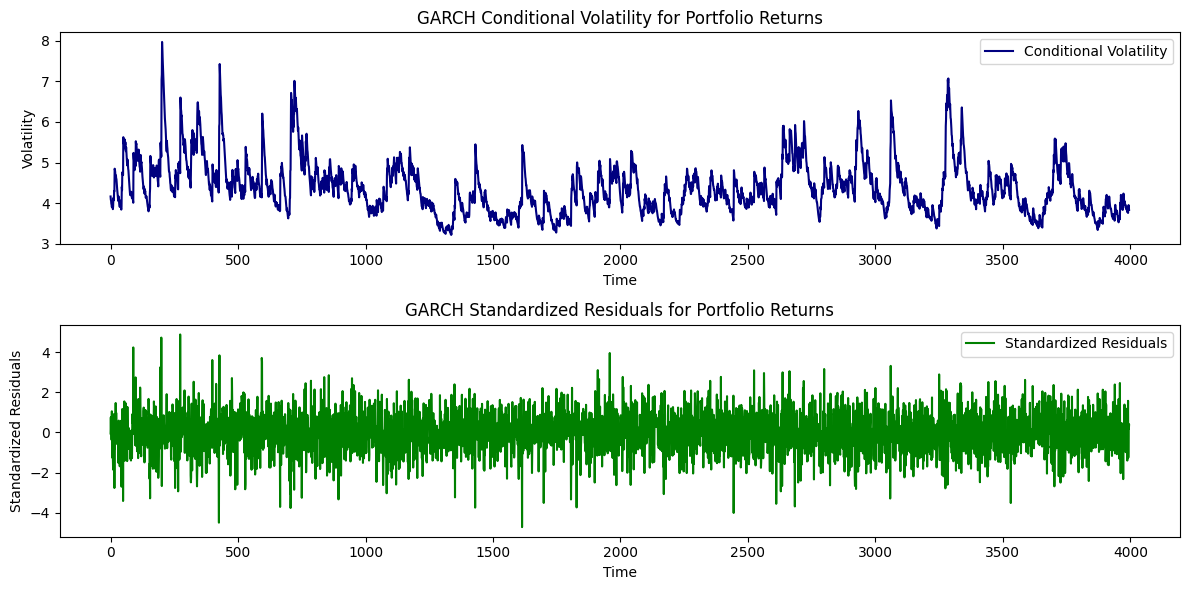


=== VaR and Expected Shortfall Results ===
1-day ahead 1% VaR: -8.652638
2-day ahead 1% VaR: -8.695883
1-day ahead 1% Expected Shortfall: 10.221727
2-day ahead 1% Expected Shortfall: 10.271270

=== VaR Backtesting Results ===
   Total Observations  VaR Breaches  Kupiec Test Statistic  Kupiec P-Value  \
0                3996            57             975.482661             0.0   

   Binomial Test P-Value  1-Day Expected Shortfall  
0               0.995868                 10.217911  


In [26]:
#EXERCISE 7: BACKTESTING AND MAYBE KUPIEK?
#I'm just building on the code in exercise 6 here, so I haven't included the ones that are repeated.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm, jarque_bera, chi2, binom, t
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg

# Load new dataset
df = pd.read_csv("UK-US stock data - Sheet1.csv")

# Define portfolio weights
data_columns = ['rjpmus', 'rjpmuk', 'rmscius', 'rmsciuk']
weights = np.array([0.30, 0.30, 0.20, 0.20])

# Calculate portfolio returns and scale the data
data_assets = df[data_columns] * 1000
portfolio_returns = np.dot(data_assets, weights)

df["Portfolio_Returns"] = portfolio_returns
df = df.dropna()
portfolio_returns = df["Portfolio_Returns"]

# Fit AR(1) model for the mean equation
ar_model = sm.tsa.ARIMA(portfolio_returns, order=(1, 0, 0)).fit()
ar_resid = ar_model.resid

# Fit GARCH(1,1) model with Student-t innovations
garch_model = arch_model(ar_resid, vol='Garch', p=1, q=1, dist='t')
garch_fit = garch_model.fit(disp="off")

# Print GARCH Model Summary
print("GARCH(1,1) Model Results:")
print(garch_fit.summary())

# Store conditional volatility
conditional_vol = garch_fit.conditional_volatility

# Extract standardized residuals
garch_std_resids = garch_fit.resid / conditional_vol

# Perform Box-Ljung Test for autocorrelation in standardized residuals
lb_test = acorr_ljungbox(garch_std_resids, lags=[20], return_df=True)
lb_stat, lb_pval = lb_test["lb_stat"].values[0], lb_test["lb_pvalue"].values[0]

# Perform Jarque-Bera Test for normality
jb_stat, jb_p_value = jarque_bera(garch_std_resids)

# Print test results
print("\n=== Serial Correlation (BL) and Normality (JB) Test Results ===")
print(f"Box-Ljung Test:")
print(f"\tBox-Ljung Stat: {lb_stat:.4f} | p-value: {lb_pval:.4f}")
print(f"Jarque-Bera Test:")
print(f"\tJarque-Bera Stat: {jb_stat:.4f} | p-value: {jb_p_value:.4f}")

# Plot Conditional Volatility & Standardized Residuals
plt.figure(figsize=(12, 6))

# Conditional Volatility
plt.subplot(2, 1, 1)
plt.plot(conditional_vol, label="Conditional Volatility", color='navy')
plt.title("GARCH Conditional Volatility for Portfolio Returns")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()

# Standardized Residuals
plt.subplot(2, 1, 2)
plt.plot(garch_std_resids, label="Standardized Residuals", color='green')
plt.title("GARCH Standardized Residuals for Portfolio Returns")
plt.xlabel("Time")
plt.ylabel("Standardized Residuals")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

# Forecast conditional variance for 1 and 2 days ahead
forecast = garch_fit.forecast(horizon=2)
cond_vol_1_day = np.sqrt(forecast.variance.iloc[-1, 0])
cond_vol_2_day = np.sqrt(forecast.variance.iloc[-1, 1])

# Compute 1% VaR & Expected Shortfall using Student-t distribution
z_alpha = norm.ppf(0.01)  # Standard normal quantile
mean_r_portfolio = np.mean(portfolio_returns)

# Compute VaR
VaR_1_day = mean_r_portfolio + z_alpha * cond_vol_1_day
VaR_2_day = mean_r_portfolio + z_alpha * cond_vol_2_day

# Compute Expected Shortfall (Conditional VaR)
pdf_z_alpha = norm.pdf(z_alpha)
ES_1_day = mean_r_portfolio + (pdf_z_alpha / 0.01) * cond_vol_1_day
ES_2_day = mean_r_portfolio + (pdf_z_alpha / 0.01) * cond_vol_2_day

# Print VaR and Expected Shortfall results
print("\n=== VaR and Expected Shortfall Results ===")
print(f"1-day ahead 1% VaR: {VaR_1_day:.6f}")
print(f"2-day ahead 1% VaR: {VaR_2_day:.6f}")
print(f"1-day ahead 1% Expected Shortfall: {ES_1_day:.6f}")
print(f"2-day ahead 1% Expected Shortfall: {ES_2_day:.6f}")

# Backtesting: Calculate VaR breaches
VaR = conditional_vol * norm.ppf(0.01)
breaches = np.array(portfolio_returns < VaR)
num_breaches = breaches.sum()
total_obs = len(portfolio_returns)

# Kupiec's Likelihood Ratio Test for VaR backtesting
def kupiec_lik_test(num_breaches, total_obs, alpha=0.01):
    expected_fail_rate = alpha
    actual_fail_rate = num_breaches / total_obs

    likelihood_ratio = -2 * (
        np.log((1 - expected_fail_rate) ** (total_obs - num_breaches)) +
        np.log(expected_fail_rate ** num_breaches) -
        np.log((1 - actual_fail_rate) ** (total_obs - num_breaches)) +
        np.log(actual_fail_rate ** num_breaches)
    )

    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)

    return likelihood_ratio, p_value

kupiec_stat, kupiec_p_value = kupiec_lik_test(num_breaches, total_obs)

# Binomial test for VaR predictive accuracy
binomial_p_value = binom.cdf(num_breaches, total_obs, 0.01)

# Expected Shortfall 1-Day
expected_shortfall_series = conditional_vol * norm.pdf(norm.ppf(0.01)) / 0.01

# Create DataFrame for backtesting results
backtest = pd.DataFrame({
    "Total Observations": [total_obs],
    "VaR Breaches": [num_breaches],
    "Kupiec Test Statistic": [kupiec_stat],
    "Kupiec P-Value": [kupiec_p_value],
    "Binomial Test P-Value": [binomial_p_value],
    "1-Day Expected Shortfall": [expected_shortfall_series.iloc[-1]]
})

print("\n=== VaR Backtesting Results ===")
print(backtest)

*I'd expect 1% of the observations as breaches so about 40 breaches. However, I got 57 which is greater than 40, which suggests to me that the model is underestimating the risk. The Kupiec Test as well rejects the model , as it has a p-value of 0, which again suggests the model is not capturing the risk properly. The binomial test p-value however being 0.997293, implies to me that the breaches do occur randomly. The Expected Shortfall is also big so this means that the losses that are past the 1% VaR bar are much more severe.

So, becasue i had much high VaR breaches than normal, I tried to reduce it by using GARCH(1,1) with Student-t. Immediately I see taht my VaR breaches reduces to 25, which is now less than my expected 40, 25 is better than 58, which tells me that this model does a better job at modelling the risk. I also get a lower expected shortfall.